In [ ]:
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/Datasets'

In [5]:
(X, Y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
gpus = tf.config.list_physical_devices('GPU')

In [7]:
for gpu in gpus:
    print(f'Name: {gpu.name}')
    print(f'Type: {gpu.device_type}')

Name: /physical_device:GPU:0
Type: GPU


In [13]:
# Normalising Images

X = X.astype('float32') / 255
X = X.reshape(-1, 28, 28, 1)

x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1)

In [14]:
# One Hot Encoding

Y = to_categorical(Y, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [15]:
X_train, x_val, Y_train, y_val = train_test_split(
                    X, Y, test_size = 0.2, random_state = 42
                )

In [8]:
model = Sequential([
    Conv2D(
            filters = 32, kernel_size = (3, 3),
            activation = 'relu', input_shape = (28, 28, 1)
    ),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation = 'relu'
    ),
    MaxPooling2D(pool_size = (2, 2)),
    Flatten(),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.5),
    Dense(units = 10, activation = 'softmax')
])

/Users/admin/Library/CloudStorage/OneDrive-UniversityofHertfordshire/code/DSA/tf_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-13 08:36:47.223544: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-13 08:36:47.224168: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-13 08:36:47.224185: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-13 08:36:47.224631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-13 08:36:47.225027: I tensorflow/core/co

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr_scheduler = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 10000,
    decay_rate = 0.96,
    staircase = True
)

model.compile(
    optimizer = Adam(learning_rate = lr_scheduler),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Callback for early stopping

model_path = 'models'

early_stopping_cb = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

# Callback for saving best model
model_checkpoint = ModelCheckpoint(
    filepath = 'models/num_model.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

assert os.path.exists(model_path)

In [28]:
history = model.fit(
            X_train,
            Y_train,
            batch_size = 64,
            epochs = 20,
            validation_data = (x_val, y_val),
            verbose = 1,
            callbacks = [early_stopping_cb, model_checkpoint]
        )

Epoch 1/20
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9682 - loss: 0.1179
Epoch 1: val_accuracy improved from -inf to 0.98325, saving model to models/num_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9682 - loss: 0.1179 - val_accuracy: 0.9833 - val_loss: 0.0629
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9710 - loss: 0.1151
Epoch 2: val_accuracy did not improve from 0.98325
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.9710 - loss: 0.1151 - val_accuracy: 0.9822 - val_loss: 0.0818
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9728 - loss: 0.1279
Epoch 3: val_accuracy improved from 0.98325 to 0.98492, saving model to models/num_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.9728 - loss: 0.1279 - val_accuracy: 0.9849 - val_loss: 0.0743
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9759 - loss: 0.1127
Epoch 4: val_accuracy improved from 0.98492 to 0.98675, s

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label: 6


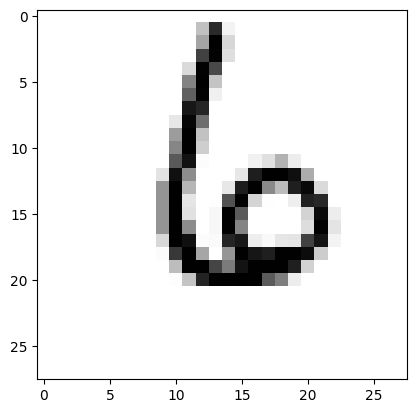

In [69]:
# Predict on a single sample
import random

num = random.randint(1, 2000)

# single_prediction = model.predict(X[num].reshape(1, 28, 28, 1))
single_prediction = model.predict(X[num].reshape(-1, 28, 28, 1))
plt.imshow(X[num], cmap = 'Greys')
predicted_class = np.argmax(single_prediction)
print(f"Predicted Label: {predicted_class}")

In [70]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(X)

predicted_classes = np.argmax(predictions, axis = 1)
print(predicted_classes)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
[5 0 4 ... 5 6 8]


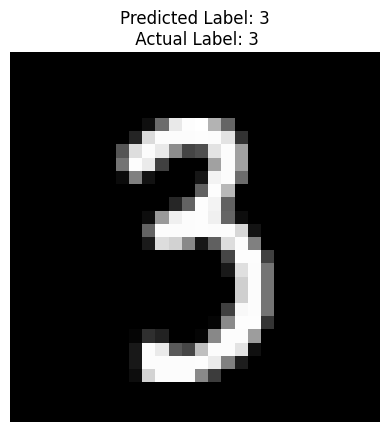

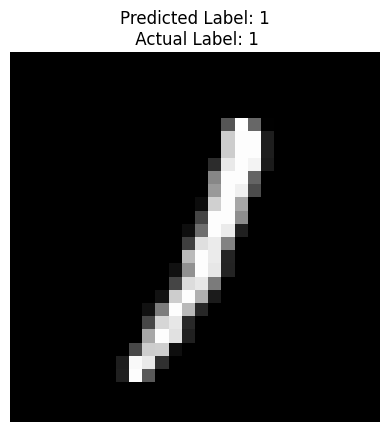

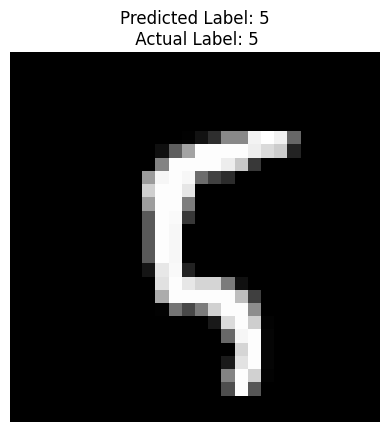

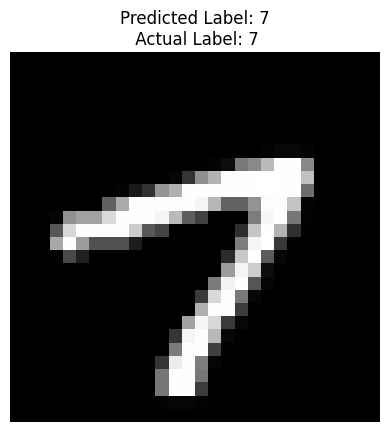

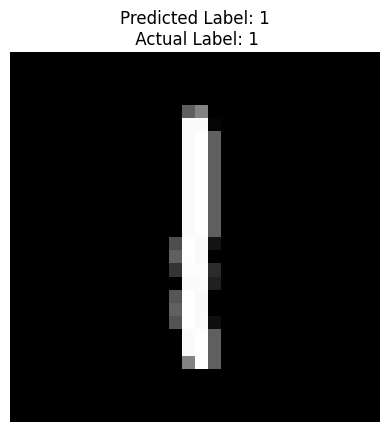

In [77]:
# Visualize first 5 samples

num = random.randint(1, 2000)

for i in range(5):
    plt.imshow(X[i + num].reshape(28, 28), cmap = 'gray')  # Display the image
    plt.title(f"Predicted Label: {predicted_classes[i + num]}\n Actual Label: {np.argmax(Y[i + num])}")
    plt.axis('off')
    plt.show()

In [78]:
accuracy = history.history['accuracy']
loss = history.history['loss']
v_acc = history.history['val_accuracy']
v_loss = history.history['val_loss']

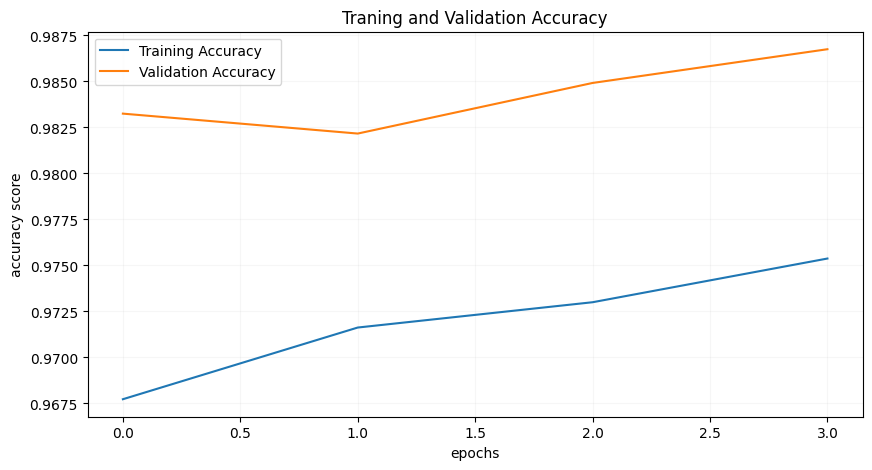

In [79]:
plt.figure(figsize = (10, 5))
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(v_acc, label = 'Validation Accuracy')
plt.title('Traning and Validation Accuracy')
plt.grid(alpha = 0.1)
plt.xlabel('epochs')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

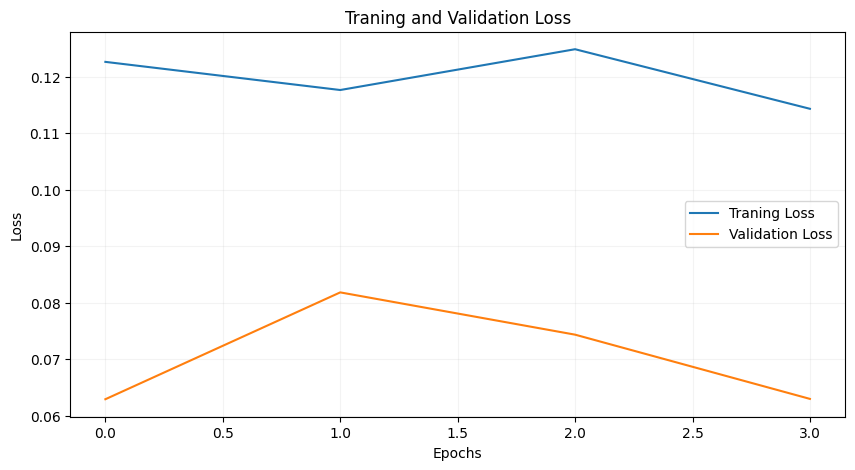

In [80]:
plt.figure(figsize = (10, 5))
plt.plot(loss, label = 'Traning Loss')
plt.plot(v_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha = 0.15)
plt.title('Traning and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Training the dataset on symbols too

# data = tf.data.Dataset.load('/content/drive/MyDrive/dataset/my_dataset')

In [ ]:
# unpacked_data = tf.data.Dataset.as_numpy_iterator(data)

In [ ]:
# final_data = tf.data.Dataset.batch(unpacked_data)

In [383]:
symbol_path = 'dataset/math_symbols'

assert os.path.exists(symbol_path)

dataset = tf.keras.utils.image_dataset_from_directory(
        directory = symbol_path,
        # image_size = (280, 280),
        image_size = (128, 128),
        batch_size = 64,
        color_mode = 'grayscale',
        shuffle = True
    )

Found 7506 files belonging to 6 classes.


In [384]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [385]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [386]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")

Images shape: (64, 128, 128, 1)
Labels: [4 1 0 1 1 1 2 2 5 4 3 2 2 5 4 1 1 2 4 0 5 4 3 0 2 5 1 5 0 5 2 0 4 4 2 0 4
 2 2 5 1 4 4 5 5 1 0 5 5 5 2 1 3 2 4 2 3 1 1 3 2 2 0 3]


2024-12-12 11:21:49.517434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for _ in range(10):
    num = random.randint(0, 50)
    plt.imshow(images[num], cmap = 'Blues_r')
    plt.title(labels[num])
    plt.axis('off')
    plt.show()

symbol_map = ['(', ')', '+', '-', 'x', '÷']

In [387]:
def image_process(image, label):

    image = tf.cast(image, tf.float16) / 255.0

    return image, label

In [388]:
train_dataset = train_dataset.map(image_process)
val_dataset = val_dataset.map(image_process)

In [ ]:
# train_dataset = train_dataset.shuffle(buffer_size = 1000).batch(64).prefetch(buffer_size = tf.data.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size = 1000).batch(64).prefetch(buffer_size = tf.data.AUTOTUNE)

In [389]:
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [88]:
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/Datasets/Callbacks/best_model.keras')

In [390]:
sym_model = Sequential([
    Conv2D(
        filters = 32, kernel_size = (3, 3),
        activation = 'relu', input_shape = (128, 128, 1)
    ),
    BatchNormalization(),
    MaxPooling2D(pool_size = (3, 3)), # Imshape = 56, 56
    Conv2D(
        filters = 64, kernel_size = (2, 2),
        activation = 'relu'
    ),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(
        filters = 128, kernel_size = (2, 2),
        activation = 'relu'
    ),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(
        filters = 64, kernel_size = (2, 2),
        activation = 'relu'
    ),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Flatten(),
    Dense(units = 32, activation = 'relu'),
    Dropout(rate = 0.3),
    Dense(units = 6, activation = 'softmax')
])

/Users/admin/Library/CloudStorage/OneDrive-UniversityofHertfordshire/code/DSA/tf_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
best_weight_cb = ModelCheckpoint(
    filepath = 'models/symbol_model.keras',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True
)

early_stopping_cb = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

lr_scheduler = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 10000,
    decay_rate = 0.96,
    staircase = True
)

sym_model.compile(
    # optimizer = Adam(learning_rate = lr_scheduler),
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [392]:
sym_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 41, 41, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 19, 19, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,454 (423.65 KB)

 Trainable params: 107,878 (421.40 KB)

 Non-trainable params: 576 (2.25 KB)

In [393]:
symbol_history = sym_model.fit(
    train_dataset,
    validation_data = val_dataset,
    batch_size = 64,
    epochs = 20,
    verbose = 1,
    callbacks = [early_stopping_cb, best_weight_cb]
)

Epoch 1/20


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6462 - loss: 1.4812
Epoch 1: val_accuracy improved from -inf to 0.16913, saving model to models/symbol_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - accuracy: 0.6478 - loss: 1.4741 - val_accuracy: 0.1691 - val_loss: 5.3225
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9394 - loss: 0.2114
Epoch 2: val_accuracy improved from 0.16913 to 0.17181, saving model to models/symbol_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 307ms/step - accuracy: 0.9395 - loss: 0.2109 - val_accuracy: 0.1718 - val_loss: 7.6991
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9706 - loss: 0.1044
Epoch 3: val_accuracy did not improve from 0.17181
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.9706 - loss: 0.1043 - val_accuracy: 0.1604 - val_loss: 8.2532
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9823 - loss: 0.0689
Epoch 4: val_accuracy improved from 0.17181 to 0.18255, saving model 

In [394]:
sym_model.save('models/symbol_model_best.keras')

In [395]:
accuracy = symbol_history.history['accuracy']
val_acc = symbol_history.history['val_accuracy']
loss = symbol_history.history['loss']
val_loss = symbol_history.history['val_loss']

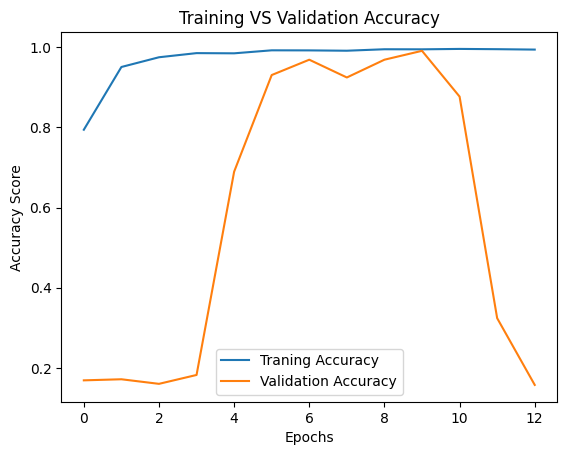

In [397]:
plt.plot(accuracy, label = 'Traning Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Training VS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

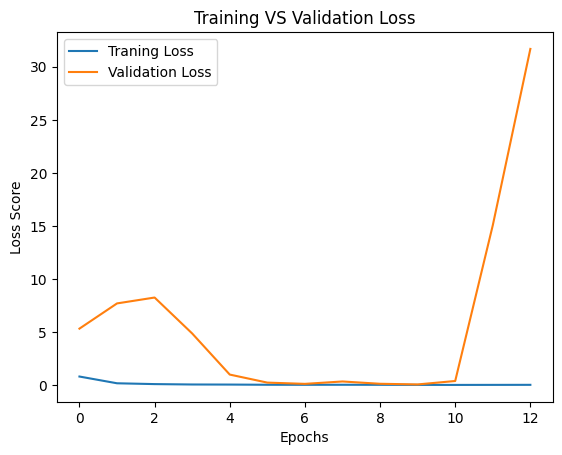

In [398]:
plt.plot(loss, label = 'Traning Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Training VS Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.legend()
plt.show()

In [425]:
for images, labels in val_dataset.take(1):
    predictions = sym_model.predict(images)
    predicted_classes = tf.argmax(predictions, axis = 1)
    actual_classes = tf.argmax(labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-12-12 11:55:09.199648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


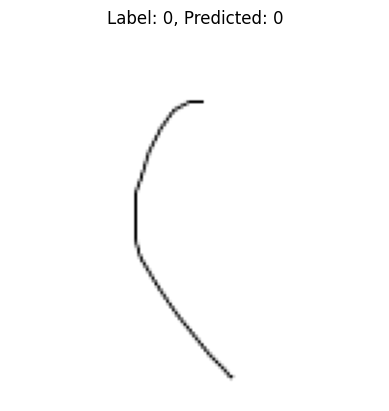

In [463]:
num = random.randint(0, len(images - 1))

# Define class names
symbol_map = ['(', ')', '+', '-', 'x', '÷']

predicted_classes

pred_symbol = symbol_map[predicted_classes[num].numpy()]

plt.imshow(images[num], cmap = 'grey')
plt.title(f'Label: {labels[num]}, Predicted: {predicted_classes[num]}')
plt.axis('off')
plt.show()

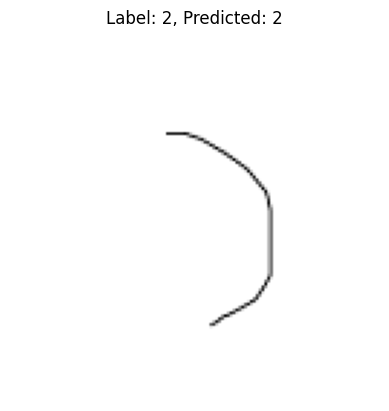

In [406]:
# tensorflow.keras.models.load_model('/content/drive/MyDrive/Datasets/Callbacks/symbol_model.keras')

In [407]:
# def freeze_pretrained_layers(model):
#     for layer in model.layers[:-1]:
#         layer.trainable = False

# def modify_final_layer(model, num_classes):
#     model.pop()
#     model.add(Dense(units = num_classes, activation = 'softmax', name = 'final_dense'))

#     return model

In [408]:
freeze_pretrained_layers(model)
symbols_model = modify_final_layer(model, 6)

NameError: name 'freeze_pretrained_layers' is not defined

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

model_cp_cb = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Datasets/Callbacks/symbol_best_model.keras',
    monitor = 'val_accuracy',
    verbose = 0,
    save_best_only = True
)

symbols_model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = symbols_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 40,
    batch_size = 64,
    verbose = 1,
    callbacks = [es_callback]
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 430ms/step - accuracy: 0.3308 - loss: 1.6116 - val_accuracy: 0.3933 - val_loss: 1.5311
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 472ms/step - accuracy: 0.3292 - loss: 1.6125 - val_accuracy: 0.4517 - val_loss: 1.5194
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.3322 - loss: 1.6120 - val_accuracy: 0.4591 - val_loss: 1.5163
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - accuracy: 0.3415 - loss: 1.6155 - val_accuracy: 0.4510 - val_loss: 1.5192
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 97s 636ms/step - accuracy: 0.3490 - loss: 1.5974 - val_accuracy: 0.4557 - val_loss: 1.5094
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 428ms/step - accuracy: 0.3337 - loss: 1.6128 - val_accuracy: 0.4591 - val_loss: 1.5141
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - accuracy: 0.3383 - loss: 1.6098 - val_accuracy: 0.4725 - val_loss: 1.5069
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 432ms/step - accuracy: 0.3236 - loss: 1.6116 - val_accu

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

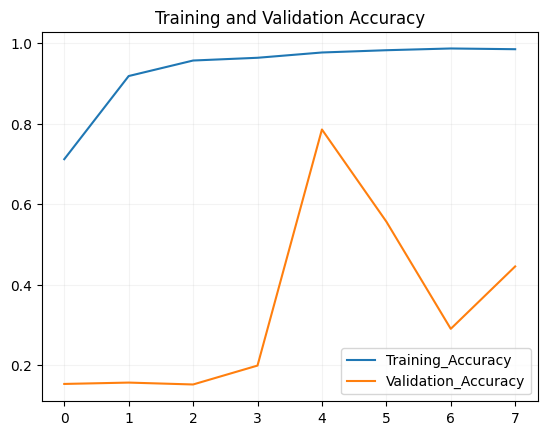

In [ ]:
plt.plot(accuracy, label = 'Training_Accuracy')
plt.plot(val_acc, label = 'Validation_Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(alpha = 0.15)
plt.legend()
plt.show()

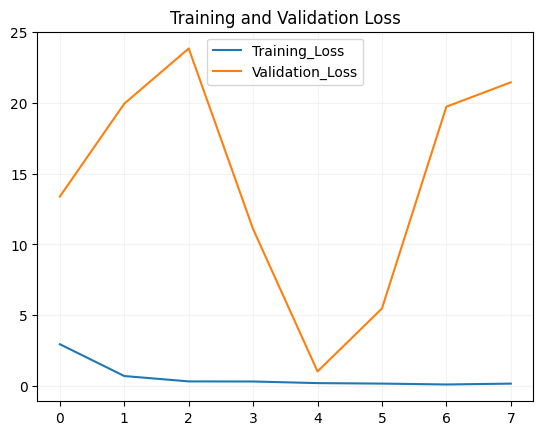

In [ ]:
plt.plot(loss, label = 'Training_Loss')
plt.plot(val_loss, label = 'Validation_Loss')
plt.title('Training and Validation Loss')
plt.grid(alpha = 0.15)
plt.legend()
plt.show()

In [ ]:
tf.keras.models.load_model('models/symbol_model1.keras')

In [ ]:
def image_process(image, label):
    # Resize image to match model input shape and normalize
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing to train and validation datasets
train_dataset = train_dataset.map(image_process)
val_dataset = val_dataset.map(image_process)

In [ ]:
sym_model.evaluate(val_dataset, batch_size = 64)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_18" is incompatible with the layer: expected axis -1 of input shape to have value 6400, but received input with shape (None, 1024)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# for images, labels in val_dataset.take(1):
#     predictions = sym_model.predict(images)
#     predicted_classes = tf.argmax(predictions)
#     actual_classes = tf.argmax(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw Probabilities: [[6.5134213e-12 5.2045935e-01 1.5603542e-06 5.5039232e-16 4.7953910e-01
  5.9193174e-19]]
Predicted Class: 1, Label: )
Actual Label: 1


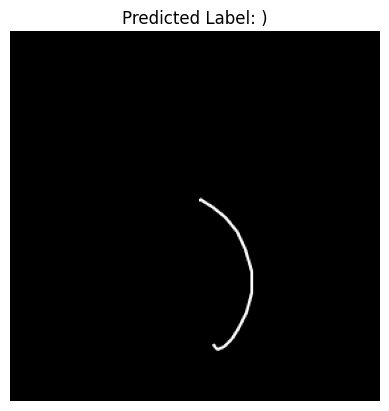

In [ ]:
num = random.randint(0, 50)

# Define class names
class_names = ['(', ')', '+', '-', 'x', '÷']  # Adjust to your actual classes

# Ensure the image is reshaped to (1, 280, 280, 1)
input_image = tf.reshape(images[num], (1, 280, 280, 1))

label = labels[num]

# Predict the probabilities
predictions = sym_model.predict(input_image)

# Print raw probabilities
print("Raw Probabilities:", predictions)

# Convert probabilities to predicted class index
predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

# Map to class label
predicted_label = class_names[predicted_class]
print(f"Predicted Class: {predicted_class}, Label: {predicted_label}")
print(f"Actual Label: {label}")

# Visualize the image with the predicted label
plt.imshow(images[num], cmap='Greys')
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()

In [ ]:
# # Dataset pipeline for GPU acc
# batch_size = 64

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size=1000)  # Shuffle dataset
#     .batch(batch_size)  # Batch data
#     .cache()  # Cache for faster access
#     .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for GPU acceleration
# )